# 实验5. 神经网络
## 实验目的

1、实现神经网络模型和算法，解决手写数字识别问题

2、使用预设参数实现前向传播

3、实现反向传播算法

## 1. 准备数据
### 1.1 读取数据

In [30]:
from scipy.io import loadmat

data = loadmat('ex4data.mat')
X = data['X']

### 1.2 可视化手写数字图像

Visualizing Data ...


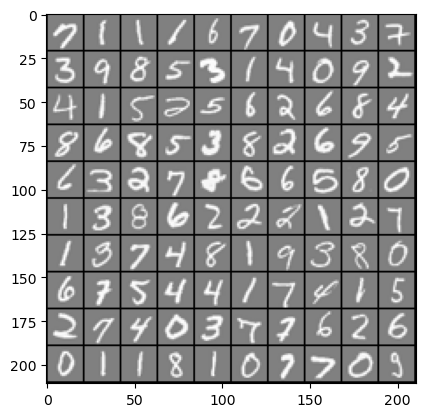

In [31]:
import scipy.optimize as op

import numpy as np
import matplotlib.pyplot as plt

import math

def displayMNISTImage(x, example_width=None):
    if example_width is None:
        example_width = int(math.sqrt(np.shape(x)[1]))
    example_height = (np.shape(x)[1] // example_width)
    display_rows = math.floor(math.sqrt(np.shape(x)[0]))
    display_cols = math.ceil(np.shape(x)[0] / display_rows)
    pad = 1
    display_array = -np.ones((pad + display_rows * (example_height + pad), pad + display_cols * (example_width + pad)))
    curr_ex = 0
    for i in range(display_rows):
        for j in range(display_cols):
            if curr_ex > np.shape(x)[0]:
                break
            max_val = max(abs(x[curr_ex, :]))
            i_layout = pad + i * (example_height + pad)
            j_layout = pad + j * (example_width + pad)
            display_array[i_layout: i_layout + example_height, j_layout: j_layout + example_width] = np.reshape(x[curr_ex], (example_height, example_width)).T / max_val
            curr_ex = curr_ex + 1
        if curr_ex > np.shape(x)[0]:
            break
    plt.imshow(display_array, cmap='gray')
    plt.show()

# num_labels = 10
print('Visualizing Data ...')

rand_indices = np.random.permutation(np.array(range(len(X))))
sel = X[rand_indices[0:100]]
displayMNISTImage(sel)

### 1.3数据预处理
为X添加一维x0=1。

为y进行One-Hot编码。

In [32]:
# 为X添加一维X0 = 1并转置，最后X的尺寸应为(401,5000)
# y扩展为(10,5000)的二维矩阵
# one-hot编码已经给出
m, n = X.shape

X = np.hstack((np.ones((m,1)),X)).T
y = np.zeros((10,m))
for i in range(m):
    classID = data['y'].T[0, i]
    y[classID - 1, i] = 1

## 2.神经网络模型
### 2.1 连接权重W的准备与拉伸

In [33]:
weights = loadmat('ex4weights.mat')
W1 = weights['W1']
W2 = weights['W2']

all_W = np.hstack((W1.flatten(), W2.flatten()))
print(W1.shape,W2.shape)

(25, 401) (10, 26)


### 2.2 神经网络的预测（前馈传递）

In [34]:
# 根据神经网络结构图下方的公式为神经元准备输入和输出，最后获得的a3即为整个网络的输出。
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoidGradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

def feedForwProp(W1, W2, x):
    m = x.shape[1]

    z2 = W1@x
    a2 = sigmoid(z2)
    
    a2 = np.vstack((np.ones((1,m)),a2))
    z3 = W2@a2
    a3 = sigmoid(z3)

    return a3

### 2.3 神经网络的代价函数（带正则项）

In [35]:
# 根据给出的代价函数的公式完成以下代码
def nnCostReg(all_W, x, y, lmd):
    m = x.shape[1]
    W1 = np.reshape(all_W[0 : 25 * 401], (25, 401))
    W2 = np.reshape(all_W[25 * 401 : ], (10, 26))
    '''
    code here
    '''
    cost1 = - (y * np.log(feedForwProp(W1, W2, x)) + (1 - y) * np.log(1 - feedForwProp(W1, W2, x))).sum() / m
    cost2 = (lmd / (2 * m)) * (np.sum(W1[:, 1:]**2) + np.sum(W2[:, 1:]**2))
    cost = cost1 + cost2
    return cost

### 2.4 代价函数相对模型参数的梯度（基于反向传递算法）

In [36]:
# 根据给出的梯度函数的公式完成以下代码
def nnGradReg(all_W, x, y, lmd):
    m = x.shape[1]
    n = x.shape[0]

    W1 = np.reshape(all_W[0 : 25 * 401], (25, 401))
    W2 = np.reshape(all_W[25 * 401 : ], (10, 26))
    a1 = np.vstack((np.ones((1,m)), x))
    z2 = W1@x
    a2 = sigmoid(z2)
    a2 = np.vstack((np.ones((1,m)),a2))
    z3 = W2@a2
    a3 = sigmoid(z3)
    sita3 = a3 - y
    sita2 = (W2[:,1:].T @ sita3) * sigmoidGradient(z2)
    W2Grad = (sita3 @ a2.T) / m
    W2Grad[:,1:] += (lmd/m) * W2[:,1:]
    W1Grad = (sita2 @ x.T) / m  
    W1Grad[:,1:] += (lmd/m) * W1[:,1:]
    return np.hstack((W1Grad.flatten(), W2Grad.flatten() ))

In [37]:
# 这部分用来验证你写的代价函数和梯度函数是否正确
print('Feedforward Using Neural Network ...')
lmd = 0
J = nnCostReg(all_W, X, y, lmd)
#print(X.shape,y.shape)
print('Cost at parameters (loaded from ex5weights): ', J)
print('(this value should be about 0.287629)')

print('Checking Cost Function (with Regularization) ... ')
lmd = 1
J = nnCostReg(all_W, X, y, lmd)
print('Cost at parameters (loaded from ex5weights): ', J)
print('(this value should be about 0.383770)')

print('Evaluating sigmoid gradient...')
gzGradient = sigmoidGradient(np.array([-1, -0.5, 0, 0.5, 1]))
print('Sigmoid gradient evaluated at [1 -0.5 0 0.5 1]: ', gzGradient)
print('(this value should be about [0.19661193 0.23500371 0.25       0.23500371 0.19661193])')

grad = nnGradReg(all_W, X, y, 3)

Feedforward Using Neural Network ...
Cost at parameters (loaded from ex5weights):  0.28762916516131887
(this value should be about 0.287629)
Checking Cost Function (with Regularization) ... 
Cost at parameters (loaded from ex5weights):  0.3837698590909236
(this value should be about 0.383770)
Evaluating sigmoid gradient...
Sigmoid gradient evaluated at [1 -0.5 0 0.5 1]:  [0.19661193 0.23500371 0.25       0.23500371 0.19661193]
(this value should be about [0.19661193 0.23500371 0.25       0.23500371 0.19661193])


### 2.5 最小化代价函数
#### 2.5.1初始化神经网络的参数

In [38]:
def randInitWeights(l_in, l_out):
    epsilon_init = 0.12
    return np.random.rand(l_out, l_in + 1) * 2 * epsilon_init - epsilon_init

print('Initializing Neural Network Parameters ...')
initW1 = randInitWeights(400, 25)
initW2 = randInitWeights(25, 10)
initNNParams = np.append(initW1.ravel(), initW2.ravel())
initNNParams = np.append(initW1.flatten(), initW2.flatten())

Initializing Neural Network Parameters ...


#### 2.5.2 训练网络

In [39]:
# 在本实验中，继续使用scipy.optimize.minimize()的共轭梯度法来最小化神经网络的代价函数。
print('Training Neural Network... ')
lmd = 3
result = op.minimize(nnCostReg, x0=initNNParams, args=(X, y, lmd), method='CG', jac=nnGradReg)
print(result)
W1 = np.reshape(result.x[0 : 401 * 25], (25, 401))
W2 = np.reshape(result.x[(401 * 25):], (10, 26))

Training Neural Network... 
     fun: 0.5594257961722966
     jac: array([-5.81791149e-06, -1.94778505e-22, -1.76057695e-21, ...,
       -2.94128684e-06, -4.47332948e-07, -4.35755305e-07])
 message: 'Optimization terminated successfully.'
    nfev: 2853
     nit: 1360
    njev: 2853
  status: 0
 success: True
       x: array([ 3.12021058e-01, -3.24630841e-19, -2.93429491e-18, ...,
        4.46284959e-01, -1.28901771e-01, -6.97556114e-01])


### 2.6 使用神经网络预测手写数字图片
#### 2.6.1 预测函数

In [40]:
def predict(W1, W2, x):
    a3 = feedForwProp(W1, W2, x)
    return np.argmax(a3, axis = 0)

#### 2.6.2 预测单个手写数字的准确性

In [41]:
# i为手写数字集的索引值，0~499为9；500~999为0；1000~1499为1,以此类推。你可以修改i的值，预测其他手写数字的标签
def predict_one(i):
    predOne = predict(W1, W2, X[:,[i]])
    yOne_label = (data['y'][i] - 1).flatten()
    return predOne,yOne_label
predOne,yOne_label = predict_one(100)
print("The result of the model predictions is: ",predOne)
print("The true label value is: ",yOne_label)

The result of the model predictions is:  [9]
The true label value is:  [9]


### 2.7 获得神经网络的训练准确率

In [42]:
predRslt = predict(W1, W2, X)
y_label = (data['y'] - 1).flatten()
acc_rate = (predRslt == y_label).sum() / m
print('Training Set Accuracy: {:.2f}'.format(acc_rate * 100), '%')

Training Set Accuracy: 97.70 %


## 3. 可视化隐含层

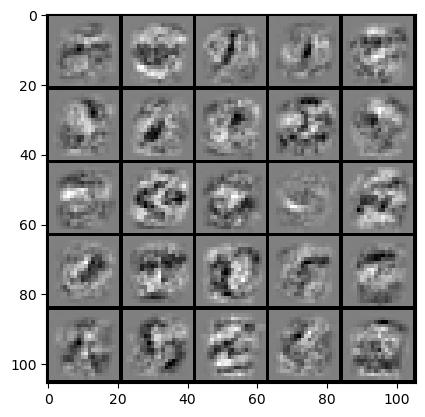

In [43]:
displayMNISTImage(W1[:, 1:])